In [1]:
from platform import python_version
print(python_version())

3.8.5


# Deep Reinforcement Learning
The model learns from experience instead of labels.

In [2]:
!pip install -q -U watermark

In [3]:
# Imports
import json 
import time
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from PIL import Image
from IPython import display 
import seaborn
import tensorflow
import keras
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD


%matplotlib inline 
seaborn.set()

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

tensorflow: 2.4.1
json      : 2.0.9
PIL       : 8.1.2
numpy     : 1.19.5
autopep8  : 1.5.6
matplotlib: 3.3.4
keras     : 2.4.3
IPython   : 7.21.0
seaborn   : 0.11.1



## Preparando o game

No jogo, frutas, representadas por azulejos brancos, caem do topo. O objetivo é pegar os frutos com um basket (representado por azulejos brancos). Se você pegar uma fruta, você obtém um ponto (sua pontuação sobe por um), se você perder uma fruta, perdeu um (sua pontuação diminui).


In [22]:
class Catch(object):
    def __init__(self, grid_size = 10):
        self.grid_size = grid_size
        self.reset()
    
    def _update_state(self, action):
        state = self.state
        if action == 0: #left
            action = -1
        elif action == 1: #stay
            action = 0
        else:
            action == 1 #right
        
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]
        
        assert len(out.shape) == 2
        self.state = out 
        
    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1 # desenha fruta
        #canvas[-1, state[2]-1:state[2] + 2] = 1  # desenha basket
        return canvas
    
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0
        
    def _is_over(self):
        if self.state[0,0] == self.grid_size - 1:
            return True
        else:
            return False
        
    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1,-1))
    
    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over
    
    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0,n,m])[np.newaxis]

In [23]:
# Setando variavies do ambiente

# o ultimo time frame faz o controle do quadro que estamos atualmente
last_frame_time = 0 

# Traduz as acoes para o vocabulario humano 
translate_action = ["Left", "Stay", "Right", "Create Ball", "End Test"]

# Tamanho do campo de jogo
grid_size = 10

In [24]:
# Definindo funcoes auxiliares para o ambiente
def display_screen(action, points, input_t):
    global last_frame_time
    print("Action %s, Points: %s" % (translate_action[action], points))
    
    # Somente ira mostrar a tela do jogo se nao for game over
    if("End" not in translate_action[action]):
        plt.imshow(input_t.reshape((grid_size,)*2), interpolation='none', cmap='gray')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    last_frame_time = set_max_fps(last_frame_time)
    
def set_max_fps(last_frame_time, FPS=1):
    current_milli_time = lambda: int(round(time.time()*1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()

## Treinando o agente

In [33]:
class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=0.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount
        
    def remember(self, states, game_over):
        # Salvando o estado na memoria
        self.memory.append([states, game_over])
        
        # Para nao lotar a memoria
        if len(self.memory) > self.max_memory:
            del self.memory[0]
            
    def get_batch(self, model, batch_size=10):
        # Quantas experiencias temos
        len_memory = len(self.memory)
        
        # Calcule o numero de acoes que podem ser tomadas no jogo
        num_actions = model.output_shape[-1]
        
        # Dimensoes do campode jogo
        env_dim = self.memory[0][0][0].shape[1]
        
        # Queremos retornar um vetor de entrada e destino com entradas de um estado observado
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        # ... e target r + gamma * max Q(s', a')
        # Observe que nosso alvo é uma matriz, com possíveis campos não só para a ação realizada, mas também 
        # para as outras ações possíveis. As ações não tomam o mesmo valor que a previsão de não afetá-las.
        targets = np.zeros((inputs.shape[0], num_actions))
        
        # Nos desenhamos estados para aprender aleatoriamente
        for i, idx, in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
          # Também precisamos saber se o jogo terminou nesse estado
            game_over = self.memory[idx][1]
            
            # Adicione o estado s à entrada
            inputs[i:i+1] = state_t
            
            # Primeiro, preenchemos os valores-alvo com as previsões do modelo. 
            # Eles não serão afetados pelo treinamento (uma vez que a perda de treinamento para eles é 0)
            targets[i] = model.predict(state_t)[0]
            
            """
            Se o jogo acabou, a recompensa esperada Q (s, a) deve ser a recompensa final r.
            Ou então o target value é r + gamma * max Q(s’,a’)
            """
            
            Q_sa = np.max(model.predict(state_tp1)[0])
            
          # Se o jogo acabou, a recompensa é a recompensa final.
            if game_over:
                targets[i, action_t] = reward_t
            # r + gamma * max Q(s’,a’)
            else:
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

## Definindo o modelo que ira aprender o valor Q

In [34]:
def baseline_model(grid_size, num_actions, hidden_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape = (grid_size ** 2,), activation = 'relu'))
    model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(lr = 0.1), 'mse')
    return model

## Definindo parametros para o treinamento

In [35]:
# Parâmetros
epsilon = .1      # Exploração
num_actions = 3   # [move_left, stay, move_right]
max_memory = 500  # Número máximo de experiências que estamos armazenando
hidden_size = 100 # Tamanho das camadas ocultas
batch_size = 1    # Número de experiências que usamos para treinar por lote
grid_size = 10    # Tamanho do campo de jogo

In [36]:
model = baseline_model(grid_size, num_actions, hidden_size)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Define game's environment
env = Catch(grid_size)

In [38]:
# Inicializa o objeto de repeticao de experiencia
exp_replay = ExperienceReplay(max_memory = max_memory)

## Treinando o modelo

O treinamento é relativamente direto. Nós deixamos o modelo jogar o jogo. Enquanto joga, ele gera dados de treinamento na forma de experiências. Usamos esses dados de treinamento para treinar nosso estimador Q.

In [43]:
def train(model, epochs, verbose = 1):
    win_cnt = 0
    win_hist = []
    
    for e in range(epochs):
        loss = 0.
        env.reset()
        game_over = False
        input_t = env.observe()
        
        while not game_over:
            # o agente esta atuando na tela do jogo observada nesse momento
            # input_t e' um vetor que contem a representacao da tela do jogo
            input_tm1 = input_t
            
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size = 1)
            else:
                q = model.predict(input_tm1)
                # escolhemos a acao com a maior recompensa esperada
                action = np.argmax(q[0])
                
            # Aplicando a acao, obtendo a recompensa e o novo estado
            input_t, reward, game_over = env.act(action)
            
            if reward == 1:
                win_cnt += 1
                
            # Experiencia
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)
            
            # Carregar lotes de experiencia
            inputs, targets = exp_replay.get_batch(model, batch_size = batch_size)
            
            # Modelo de trem sobre experiencias
            batch_loss = model.train_on_batch(inputs, targets)
            
            loss += batch_loss
            
        if verbose > 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e, epochs, loss, win_cnt))
            
        win_hist.append(win_cnt)
        
    return win_hist

## Fazendo o agente jogar varias vezes

In [44]:
epoch = 5000 # numero de jogos 

hist = train(model, epoch, verbose = 1)
print("Treinamento Finalizado")

Epoch 000/5000 | Loss 0.0069 | Win count 1
Epoch 001/5000 | Loss 0.0089 | Win count 1
Epoch 002/5000 | Loss 0.3071 | Win count 2
Epoch 003/5000 | Loss 0.0019 | Win count 2
Epoch 004/5000 | Loss 0.0057 | Win count 3
Epoch 005/5000 | Loss 1.0226 | Win count 4
Epoch 006/5000 | Loss 0.2667 | Win count 4
Epoch 007/5000 | Loss 0.3216 | Win count 4
Epoch 008/5000 | Loss 0.6127 | Win count 4
Epoch 009/5000 | Loss 0.6376 | Win count 5
Epoch 010/5000 | Loss 0.6783 | Win count 5
Epoch 011/5000 | Loss 0.2977 | Win count 5
Epoch 012/5000 | Loss 0.0441 | Win count 5
Epoch 013/5000 | Loss 0.6853 | Win count 6
Epoch 014/5000 | Loss 0.1344 | Win count 6
Epoch 015/5000 | Loss 0.0603 | Win count 6
Epoch 016/5000 | Loss 1.0081 | Win count 6
Epoch 017/5000 | Loss 0.0158 | Win count 6
Epoch 018/5000 | Loss 0.8304 | Win count 6
Epoch 019/5000 | Loss 0.6367 | Win count 6
Epoch 020/5000 | Loss 0.2996 | Win count 7
Epoch 021/5000 | Loss 0.8562 | Win count 7
Epoch 022/5000 | Loss 0.4207 | Win count 8
Epoch 023/5

Epoch 187/5000 | Loss 0.0722 | Win count 49
Epoch 188/5000 | Loss 0.0131 | Win count 50
Epoch 189/5000 | Loss 0.2610 | Win count 50
Epoch 190/5000 | Loss 0.0871 | Win count 51
Epoch 191/5000 | Loss 0.1986 | Win count 51
Epoch 192/5000 | Loss 0.2403 | Win count 51
Epoch 193/5000 | Loss 0.0349 | Win count 52
Epoch 194/5000 | Loss 0.0877 | Win count 52
Epoch 195/5000 | Loss 0.0843 | Win count 52
Epoch 196/5000 | Loss 0.9180 | Win count 52
Epoch 197/5000 | Loss 0.0577 | Win count 52
Epoch 198/5000 | Loss 0.0294 | Win count 52
Epoch 199/5000 | Loss 0.0584 | Win count 52
Epoch 200/5000 | Loss 0.7388 | Win count 52
Epoch 201/5000 | Loss 0.0216 | Win count 52
Epoch 202/5000 | Loss 0.2209 | Win count 53
Epoch 203/5000 | Loss 0.0297 | Win count 54
Epoch 204/5000 | Loss 0.0802 | Win count 54
Epoch 205/5000 | Loss 0.0325 | Win count 54
Epoch 206/5000 | Loss 0.0843 | Win count 54
Epoch 207/5000 | Loss 0.1090 | Win count 55
Epoch 208/5000 | Loss 0.0525 | Win count 55
Epoch 209/5000 | Loss 0.0630 | W

Epoch 374/5000 | Loss 0.3057 | Win count 103
Epoch 375/5000 | Loss 0.0838 | Win count 103
Epoch 376/5000 | Loss 0.1510 | Win count 103
Epoch 377/5000 | Loss 0.0458 | Win count 103
Epoch 378/5000 | Loss 1.2968 | Win count 103
Epoch 379/5000 | Loss 1.3803 | Win count 104
Epoch 380/5000 | Loss 0.0383 | Win count 105
Epoch 381/5000 | Loss 0.8494 | Win count 105
Epoch 382/5000 | Loss 0.3398 | Win count 105
Epoch 383/5000 | Loss 0.6538 | Win count 106
Epoch 384/5000 | Loss 0.0903 | Win count 106
Epoch 385/5000 | Loss 0.2649 | Win count 106
Epoch 386/5000 | Loss 0.0218 | Win count 106
Epoch 387/5000 | Loss 0.1269 | Win count 107
Epoch 388/5000 | Loss 0.1558 | Win count 107
Epoch 389/5000 | Loss 0.1304 | Win count 107
Epoch 390/5000 | Loss 0.0248 | Win count 107
Epoch 391/5000 | Loss 0.0586 | Win count 107
Epoch 392/5000 | Loss 0.0190 | Win count 107
Epoch 393/5000 | Loss 0.8918 | Win count 107
Epoch 394/5000 | Loss 0.3104 | Win count 108
Epoch 395/5000 | Loss 0.0118 | Win count 108
Epoch 396/

Epoch 557/5000 | Loss 0.0115 | Win count 161
Epoch 558/5000 | Loss 0.0070 | Win count 161
Epoch 559/5000 | Loss 0.0033 | Win count 161
Epoch 560/5000 | Loss 0.0143 | Win count 161
Epoch 561/5000 | Loss 0.0634 | Win count 161
Epoch 562/5000 | Loss 0.0131 | Win count 162
Epoch 563/5000 | Loss 0.0175 | Win count 163
Epoch 564/5000 | Loss 1.2168 | Win count 163
Epoch 565/5000 | Loss 0.1775 | Win count 163
Epoch 566/5000 | Loss 0.1161 | Win count 164
Epoch 567/5000 | Loss 0.0158 | Win count 164
Epoch 568/5000 | Loss 0.5539 | Win count 164
Epoch 569/5000 | Loss 0.0232 | Win count 164
Epoch 570/5000 | Loss 0.0884 | Win count 164
Epoch 571/5000 | Loss 0.1158 | Win count 165
Epoch 572/5000 | Loss 0.1273 | Win count 165
Epoch 573/5000 | Loss 0.0529 | Win count 166
Epoch 574/5000 | Loss 0.0067 | Win count 166
Epoch 575/5000 | Loss 0.0886 | Win count 166
Epoch 576/5000 | Loss 0.1544 | Win count 166
Epoch 577/5000 | Loss 1.1739 | Win count 166
Epoch 578/5000 | Loss 0.0351 | Win count 166
Epoch 579/

Epoch 740/5000 | Loss 0.0253 | Win count 219
Epoch 741/5000 | Loss 0.0150 | Win count 219
Epoch 742/5000 | Loss 0.1166 | Win count 219
Epoch 743/5000 | Loss 0.1841 | Win count 219
Epoch 744/5000 | Loss 0.0297 | Win count 219
Epoch 745/5000 | Loss 0.4633 | Win count 220
Epoch 746/5000 | Loss 0.1748 | Win count 220
Epoch 747/5000 | Loss 0.0238 | Win count 220
Epoch 748/5000 | Loss 0.1093 | Win count 221
Epoch 749/5000 | Loss 0.0229 | Win count 222
Epoch 750/5000 | Loss 0.1175 | Win count 222
Epoch 751/5000 | Loss 0.0779 | Win count 222
Epoch 752/5000 | Loss 0.1291 | Win count 223
Epoch 753/5000 | Loss 0.0257 | Win count 224
Epoch 754/5000 | Loss 0.0767 | Win count 224
Epoch 755/5000 | Loss 0.1578 | Win count 224
Epoch 756/5000 | Loss 1.4441 | Win count 225
Epoch 757/5000 | Loss 0.0195 | Win count 226
Epoch 758/5000 | Loss 0.3405 | Win count 226
Epoch 759/5000 | Loss 0.1385 | Win count 226
Epoch 760/5000 | Loss 0.0452 | Win count 226
Epoch 761/5000 | Loss 0.0236 | Win count 226
Epoch 762/

Epoch 923/5000 | Loss 0.0075 | Win count 288
Epoch 924/5000 | Loss 0.2413 | Win count 288
Epoch 925/5000 | Loss 0.0033 | Win count 288
Epoch 926/5000 | Loss 0.0047 | Win count 289
Epoch 927/5000 | Loss 0.3402 | Win count 290
Epoch 928/5000 | Loss 0.5324 | Win count 290
Epoch 929/5000 | Loss 0.1965 | Win count 290
Epoch 930/5000 | Loss 0.4481 | Win count 291
Epoch 931/5000 | Loss 0.6676 | Win count 291
Epoch 932/5000 | Loss 0.1074 | Win count 291
Epoch 933/5000 | Loss 0.7236 | Win count 291
Epoch 934/5000 | Loss 0.0085 | Win count 292
Epoch 935/5000 | Loss 0.1503 | Win count 292
Epoch 936/5000 | Loss 0.0039 | Win count 293
Epoch 937/5000 | Loss 0.1000 | Win count 293
Epoch 938/5000 | Loss 0.1380 | Win count 294
Epoch 939/5000 | Loss 0.0351 | Win count 295
Epoch 940/5000 | Loss 0.0041 | Win count 295
Epoch 941/5000 | Loss 0.0116 | Win count 295
Epoch 942/5000 | Loss 0.0100 | Win count 295
Epoch 943/5000 | Loss 0.5550 | Win count 295
Epoch 944/5000 | Loss 0.6015 | Win count 296
Epoch 945/

Epoch 1103/5000 | Loss 0.1178 | Win count 360
Epoch 1104/5000 | Loss 0.5324 | Win count 361
Epoch 1105/5000 | Loss 0.4079 | Win count 362
Epoch 1106/5000 | Loss 0.0072 | Win count 363
Epoch 1107/5000 | Loss 0.5707 | Win count 364
Epoch 1108/5000 | Loss 0.0672 | Win count 364
Epoch 1109/5000 | Loss 0.9344 | Win count 365
Epoch 1110/5000 | Loss 0.7854 | Win count 366
Epoch 1111/5000 | Loss 0.0421 | Win count 366
Epoch 1112/5000 | Loss 0.1125 | Win count 367
Epoch 1113/5000 | Loss 0.3450 | Win count 368
Epoch 1114/5000 | Loss 0.5064 | Win count 368
Epoch 1115/5000 | Loss 0.9992 | Win count 368
Epoch 1116/5000 | Loss 0.0393 | Win count 368
Epoch 1117/5000 | Loss 0.7214 | Win count 369
Epoch 1118/5000 | Loss 0.0123 | Win count 370
Epoch 1119/5000 | Loss 0.2920 | Win count 371
Epoch 1120/5000 | Loss 0.6943 | Win count 371
Epoch 1121/5000 | Loss 0.2772 | Win count 372
Epoch 1122/5000 | Loss 0.0112 | Win count 372
Epoch 1123/5000 | Loss 0.0095 | Win count 372
Epoch 1124/5000 | Loss 0.0059 | Wi

Epoch 1282/5000 | Loss 0.2508 | Win count 426
Epoch 1283/5000 | Loss 0.0927 | Win count 426
Epoch 1284/5000 | Loss 0.0808 | Win count 426
Epoch 1285/5000 | Loss 0.0168 | Win count 427
Epoch 1286/5000 | Loss 0.0270 | Win count 427
Epoch 1287/5000 | Loss 0.9768 | Win count 427
Epoch 1288/5000 | Loss 0.1127 | Win count 428
Epoch 1289/5000 | Loss 0.2823 | Win count 429
Epoch 1290/5000 | Loss 1.6744 | Win count 429
Epoch 1291/5000 | Loss 0.0283 | Win count 429
Epoch 1292/5000 | Loss 0.6957 | Win count 429
Epoch 1293/5000 | Loss 0.4306 | Win count 429
Epoch 1294/5000 | Loss 0.0100 | Win count 430
Epoch 1295/5000 | Loss 0.0821 | Win count 430
Epoch 1296/5000 | Loss 1.0758 | Win count 430
Epoch 1297/5000 | Loss 0.0091 | Win count 430
Epoch 1298/5000 | Loss 0.2136 | Win count 431
Epoch 1299/5000 | Loss 0.3473 | Win count 432
Epoch 1300/5000 | Loss 0.7056 | Win count 433
Epoch 1301/5000 | Loss 0.0069 | Win count 433
Epoch 1302/5000 | Loss 0.1181 | Win count 433
Epoch 1303/5000 | Loss 0.0896 | Wi

Epoch 1461/5000 | Loss 0.7476 | Win count 497
Epoch 1462/5000 | Loss 0.2850 | Win count 497
Epoch 1463/5000 | Loss 0.0031 | Win count 497
Epoch 1464/5000 | Loss 0.0670 | Win count 497
Epoch 1465/5000 | Loss 0.1972 | Win count 497
Epoch 1466/5000 | Loss 0.4774 | Win count 497
Epoch 1467/5000 | Loss 0.1831 | Win count 497
Epoch 1468/5000 | Loss 0.3396 | Win count 497
Epoch 1469/5000 | Loss 0.4275 | Win count 497
Epoch 1470/5000 | Loss 0.7426 | Win count 497
Epoch 1471/5000 | Loss 0.3255 | Win count 498
Epoch 1472/5000 | Loss 0.0423 | Win count 498
Epoch 1473/5000 | Loss 0.8037 | Win count 498
Epoch 1474/5000 | Loss 0.7967 | Win count 499
Epoch 1475/5000 | Loss 0.0037 | Win count 500
Epoch 1476/5000 | Loss 0.6347 | Win count 501
Epoch 1477/5000 | Loss 0.3231 | Win count 501
Epoch 1478/5000 | Loss 0.0216 | Win count 501
Epoch 1479/5000 | Loss 0.8058 | Win count 502
Epoch 1480/5000 | Loss 0.1185 | Win count 503
Epoch 1481/5000 | Loss 0.0067 | Win count 503
Epoch 1482/5000 | Loss 0.0102 | Wi

Epoch 1640/5000 | Loss 0.2218 | Win count 546
Epoch 1641/5000 | Loss 0.1168 | Win count 547
Epoch 1642/5000 | Loss 0.0807 | Win count 548
Epoch 1643/5000 | Loss 0.7705 | Win count 548
Epoch 1644/5000 | Loss 0.8374 | Win count 548
Epoch 1645/5000 | Loss 0.4412 | Win count 548
Epoch 1646/5000 | Loss 0.0087 | Win count 548
Epoch 1647/5000 | Loss 0.1858 | Win count 548
Epoch 1648/5000 | Loss 0.0772 | Win count 548
Epoch 1649/5000 | Loss 0.0811 | Win count 549
Epoch 1650/5000 | Loss 0.0108 | Win count 550
Epoch 1651/5000 | Loss 0.6309 | Win count 551
Epoch 1652/5000 | Loss 0.4663 | Win count 551
Epoch 1653/5000 | Loss 1.5087 | Win count 551
Epoch 1654/5000 | Loss 0.1420 | Win count 551
Epoch 1655/5000 | Loss 0.2377 | Win count 551
Epoch 1656/5000 | Loss 0.4692 | Win count 551
Epoch 1657/5000 | Loss 0.2260 | Win count 551
Epoch 1658/5000 | Loss 1.1113 | Win count 551
Epoch 1659/5000 | Loss 0.0254 | Win count 552
Epoch 1660/5000 | Loss 0.4406 | Win count 553
Epoch 1661/5000 | Loss 0.1511 | Wi

Epoch 1819/5000 | Loss 0.6283 | Win count 615
Epoch 1820/5000 | Loss 0.0052 | Win count 615
Epoch 1821/5000 | Loss 0.0075 | Win count 615
Epoch 1822/5000 | Loss 0.7243 | Win count 615
Epoch 1823/5000 | Loss 0.9351 | Win count 615
Epoch 1824/5000 | Loss 0.3463 | Win count 616
Epoch 1825/5000 | Loss 0.7758 | Win count 616
Epoch 1826/5000 | Loss 0.0039 | Win count 617
Epoch 1827/5000 | Loss 0.0026 | Win count 617
Epoch 1828/5000 | Loss 0.5540 | Win count 617
Epoch 1829/5000 | Loss 0.0095 | Win count 618
Epoch 1830/5000 | Loss 0.6934 | Win count 618
Epoch 1831/5000 | Loss 0.0044 | Win count 618
Epoch 1832/5000 | Loss 0.2419 | Win count 618
Epoch 1833/5000 | Loss 0.2260 | Win count 618
Epoch 1834/5000 | Loss 0.1727 | Win count 618
Epoch 1835/5000 | Loss 0.0041 | Win count 618
Epoch 1836/5000 | Loss 0.0067 | Win count 618
Epoch 1837/5000 | Loss 0.0049 | Win count 618
Epoch 1838/5000 | Loss 0.0066 | Win count 619
Epoch 1839/5000 | Loss 1.2024 | Win count 619
Epoch 1840/5000 | Loss 0.9159 | Wi

Epoch 1998/5000 | Loss 0.9721 | Win count 679
Epoch 1999/5000 | Loss 0.1680 | Win count 680
Epoch 2000/5000 | Loss 0.0290 | Win count 680
Epoch 2001/5000 | Loss 0.8407 | Win count 680
Epoch 2002/5000 | Loss 0.0328 | Win count 680
Epoch 2003/5000 | Loss 0.0151 | Win count 680
Epoch 2004/5000 | Loss 0.6215 | Win count 681
Epoch 2005/5000 | Loss 0.2293 | Win count 682
Epoch 2006/5000 | Loss 1.0369 | Win count 682
Epoch 2007/5000 | Loss 0.4385 | Win count 683
Epoch 2008/5000 | Loss 1.7815 | Win count 684
Epoch 2009/5000 | Loss 0.0457 | Win count 685
Epoch 2010/5000 | Loss 0.0271 | Win count 685
Epoch 2011/5000 | Loss 0.0067 | Win count 685
Epoch 2012/5000 | Loss 0.2136 | Win count 686
Epoch 2013/5000 | Loss 0.0074 | Win count 687
Epoch 2014/5000 | Loss 0.2331 | Win count 687
Epoch 2015/5000 | Loss 0.0088 | Win count 688
Epoch 2016/5000 | Loss 0.6110 | Win count 688
Epoch 2017/5000 | Loss 0.1141 | Win count 688
Epoch 2018/5000 | Loss 0.9259 | Win count 688
Epoch 2019/5000 | Loss 0.8768 | Wi

Epoch 2177/5000 | Loss 0.1659 | Win count 756
Epoch 2178/5000 | Loss 1.0001 | Win count 757
Epoch 2179/5000 | Loss 0.2641 | Win count 757
Epoch 2180/5000 | Loss 0.5201 | Win count 757
Epoch 2181/5000 | Loss 0.4268 | Win count 757
Epoch 2182/5000 | Loss 0.2113 | Win count 757
Epoch 2183/5000 | Loss 1.8296 | Win count 757
Epoch 2184/5000 | Loss 0.1829 | Win count 757
Epoch 2185/5000 | Loss 0.4520 | Win count 757
Epoch 2186/5000 | Loss 0.0606 | Win count 758
Epoch 2187/5000 | Loss 0.0773 | Win count 758
Epoch 2188/5000 | Loss 0.0902 | Win count 759
Epoch 2189/5000 | Loss 0.4246 | Win count 759
Epoch 2190/5000 | Loss 0.5025 | Win count 759
Epoch 2191/5000 | Loss 0.4104 | Win count 759
Epoch 2192/5000 | Loss 0.5982 | Win count 759
Epoch 2193/5000 | Loss 0.0379 | Win count 759
Epoch 2194/5000 | Loss 0.9478 | Win count 759
Epoch 2195/5000 | Loss 0.1374 | Win count 759
Epoch 2196/5000 | Loss 0.0672 | Win count 759
Epoch 2197/5000 | Loss 0.0616 | Win count 760
Epoch 2198/5000 | Loss 0.1052 | Wi

Epoch 2356/5000 | Loss 0.0082 | Win count 815
Epoch 2357/5000 | Loss 0.0088 | Win count 815
Epoch 2358/5000 | Loss 0.7971 | Win count 815
Epoch 2359/5000 | Loss 0.0089 | Win count 815
Epoch 2360/5000 | Loss 0.0137 | Win count 815
Epoch 2361/5000 | Loss 0.1414 | Win count 815
Epoch 2362/5000 | Loss 0.0055 | Win count 815
Epoch 2363/5000 | Loss 0.0063 | Win count 816
Epoch 2364/5000 | Loss 0.7663 | Win count 816
Epoch 2365/5000 | Loss 0.0198 | Win count 816
Epoch 2366/5000 | Loss 0.6497 | Win count 817
Epoch 2367/5000 | Loss 0.0005 | Win count 818
Epoch 2368/5000 | Loss 0.6694 | Win count 819
Epoch 2369/5000 | Loss 0.1469 | Win count 819
Epoch 2370/5000 | Loss 0.3535 | Win count 820
Epoch 2371/5000 | Loss 0.7640 | Win count 820
Epoch 2372/5000 | Loss 0.0035 | Win count 821
Epoch 2373/5000 | Loss 0.1327 | Win count 821
Epoch 2374/5000 | Loss 0.6025 | Win count 821
Epoch 2375/5000 | Loss 0.3403 | Win count 822
Epoch 2376/5000 | Loss 1.9998 | Win count 822
Epoch 2377/5000 | Loss 0.4884 | Wi

Epoch 2535/5000 | Loss 0.0121 | Win count 890
Epoch 2536/5000 | Loss 0.0059 | Win count 891
Epoch 2537/5000 | Loss 0.0161 | Win count 891
Epoch 2538/5000 | Loss 1.3656 | Win count 892
Epoch 2539/5000 | Loss 0.3175 | Win count 892
Epoch 2540/5000 | Loss 0.9796 | Win count 893
Epoch 2541/5000 | Loss 0.4043 | Win count 893
Epoch 2542/5000 | Loss 0.0494 | Win count 894
Epoch 2543/5000 | Loss 0.3619 | Win count 894
Epoch 2544/5000 | Loss 0.0149 | Win count 894
Epoch 2545/5000 | Loss 0.0119 | Win count 894
Epoch 2546/5000 | Loss 0.0106 | Win count 895
Epoch 2547/5000 | Loss 0.0050 | Win count 896
Epoch 2548/5000 | Loss 0.0735 | Win count 896
Epoch 2549/5000 | Loss 0.4130 | Win count 896
Epoch 2550/5000 | Loss 0.3286 | Win count 897
Epoch 2551/5000 | Loss 0.7245 | Win count 897
Epoch 2552/5000 | Loss 0.1692 | Win count 897
Epoch 2553/5000 | Loss 0.2656 | Win count 897
Epoch 2554/5000 | Loss 0.7996 | Win count 897
Epoch 2555/5000 | Loss 0.1417 | Win count 897
Epoch 2556/5000 | Loss 0.6390 | Wi

Epoch 2714/5000 | Loss 0.0129 | Win count 938
Epoch 2715/5000 | Loss 0.7788 | Win count 938
Epoch 2716/5000 | Loss 0.0276 | Win count 939
Epoch 2717/5000 | Loss 0.1096 | Win count 940
Epoch 2718/5000 | Loss 0.0943 | Win count 940
Epoch 2719/5000 | Loss 0.0071 | Win count 941
Epoch 2720/5000 | Loss 0.7860 | Win count 941
Epoch 2721/5000 | Loss 0.0284 | Win count 942
Epoch 2722/5000 | Loss 0.1995 | Win count 943
Epoch 2723/5000 | Loss 0.1524 | Win count 943
Epoch 2724/5000 | Loss 0.6837 | Win count 944
Epoch 2725/5000 | Loss 0.7659 | Win count 945
Epoch 2726/5000 | Loss 0.2804 | Win count 945
Epoch 2727/5000 | Loss 0.1854 | Win count 945
Epoch 2728/5000 | Loss 0.4894 | Win count 946
Epoch 2729/5000 | Loss 1.0782 | Win count 947
Epoch 2730/5000 | Loss 0.0170 | Win count 947
Epoch 2731/5000 | Loss 0.2161 | Win count 947
Epoch 2732/5000 | Loss 0.1282 | Win count 947
Epoch 2733/5000 | Loss 0.0162 | Win count 948
Epoch 2734/5000 | Loss 1.0921 | Win count 949
Epoch 2735/5000 | Loss 0.1669 | Wi

Epoch 2892/5000 | Loss 0.3989 | Win count 1007
Epoch 2893/5000 | Loss 0.0113 | Win count 1007
Epoch 2894/5000 | Loss 0.0975 | Win count 1007
Epoch 2895/5000 | Loss 0.4484 | Win count 1007
Epoch 2896/5000 | Loss 0.5367 | Win count 1007
Epoch 2897/5000 | Loss 0.5648 | Win count 1007
Epoch 2898/5000 | Loss 0.0035 | Win count 1007
Epoch 2899/5000 | Loss 0.0046 | Win count 1007
Epoch 2900/5000 | Loss 0.0768 | Win count 1007
Epoch 2901/5000 | Loss 0.6174 | Win count 1008
Epoch 2902/5000 | Loss 0.7441 | Win count 1008
Epoch 2903/5000 | Loss 0.4996 | Win count 1008
Epoch 2904/5000 | Loss 0.5281 | Win count 1009
Epoch 2905/5000 | Loss 0.0146 | Win count 1009
Epoch 2906/5000 | Loss 0.0283 | Win count 1009
Epoch 2907/5000 | Loss 0.2050 | Win count 1009
Epoch 2908/5000 | Loss 0.1810 | Win count 1009
Epoch 2909/5000 | Loss 0.3612 | Win count 1009
Epoch 2910/5000 | Loss 0.6353 | Win count 1009
Epoch 2911/5000 | Loss 0.1909 | Win count 1010
Epoch 2912/5000 | Loss 0.0121 | Win count 1010
Epoch 2913/50

Epoch 3067/5000 | Loss 0.2372 | Win count 1064
Epoch 3068/5000 | Loss 0.0045 | Win count 1064
Epoch 3069/5000 | Loss 0.1954 | Win count 1064
Epoch 3070/5000 | Loss 0.5696 | Win count 1065
Epoch 3071/5000 | Loss 0.6972 | Win count 1066
Epoch 3072/5000 | Loss 0.1313 | Win count 1066
Epoch 3073/5000 | Loss 0.0070 | Win count 1067
Epoch 3074/5000 | Loss 0.2382 | Win count 1067
Epoch 3075/5000 | Loss 0.0137 | Win count 1067
Epoch 3076/5000 | Loss 0.4564 | Win count 1067
Epoch 3077/5000 | Loss 0.7202 | Win count 1068
Epoch 3078/5000 | Loss 0.1207 | Win count 1069
Epoch 3079/5000 | Loss 0.0140 | Win count 1070
Epoch 3080/5000 | Loss 0.2229 | Win count 1070
Epoch 3081/5000 | Loss 0.5359 | Win count 1070
Epoch 3082/5000 | Loss 0.4284 | Win count 1070
Epoch 3083/5000 | Loss 0.2254 | Win count 1070
Epoch 3084/5000 | Loss 0.0060 | Win count 1070
Epoch 3085/5000 | Loss 0.0037 | Win count 1071
Epoch 3086/5000 | Loss 0.8399 | Win count 1071
Epoch 3087/5000 | Loss 0.0053 | Win count 1071
Epoch 3088/50

Epoch 3242/5000 | Loss 0.1892 | Win count 1141
Epoch 3243/5000 | Loss 0.0076 | Win count 1141
Epoch 3244/5000 | Loss 0.6395 | Win count 1141
Epoch 3245/5000 | Loss 0.2571 | Win count 1142
Epoch 3246/5000 | Loss 0.0676 | Win count 1143
Epoch 3247/5000 | Loss 1.2833 | Win count 1143
Epoch 3248/5000 | Loss 0.0107 | Win count 1143
Epoch 3249/5000 | Loss 0.0049 | Win count 1144
Epoch 3250/5000 | Loss 0.0038 | Win count 1145
Epoch 3251/5000 | Loss 0.7040 | Win count 1145
Epoch 3252/5000 | Loss 0.7846 | Win count 1145
Epoch 3253/5000 | Loss 0.4685 | Win count 1146
Epoch 3254/5000 | Loss 0.5168 | Win count 1146
Epoch 3255/5000 | Loss 0.4747 | Win count 1147
Epoch 3256/5000 | Loss 0.0077 | Win count 1147
Epoch 3257/5000 | Loss 0.0038 | Win count 1147
Epoch 3258/5000 | Loss 0.4643 | Win count 1148
Epoch 3259/5000 | Loss 0.1601 | Win count 1149
Epoch 3260/5000 | Loss 0.6682 | Win count 1150
Epoch 3261/5000 | Loss 0.4498 | Win count 1150
Epoch 3262/5000 | Loss 0.0514 | Win count 1150
Epoch 3263/50

Epoch 3417/5000 | Loss 0.0127 | Win count 1191
Epoch 3418/5000 | Loss 0.0240 | Win count 1191
Epoch 3419/5000 | Loss 0.0049 | Win count 1191
Epoch 3420/5000 | Loss 0.4415 | Win count 1191
Epoch 3421/5000 | Loss 0.0299 | Win count 1192
Epoch 3422/5000 | Loss 0.0141 | Win count 1193
Epoch 3423/5000 | Loss 0.3737 | Win count 1194
Epoch 3424/5000 | Loss 0.5014 | Win count 1195
Epoch 3425/5000 | Loss 0.0241 | Win count 1196
Epoch 3426/5000 | Loss 0.0292 | Win count 1197
Epoch 3427/5000 | Loss 0.0123 | Win count 1198
Epoch 3428/5000 | Loss 0.3825 | Win count 1198
Epoch 3429/5000 | Loss 0.5543 | Win count 1199
Epoch 3430/5000 | Loss 1.6443 | Win count 1199
Epoch 3431/5000 | Loss 0.3769 | Win count 1200
Epoch 3432/5000 | Loss 0.0405 | Win count 1200
Epoch 3433/5000 | Loss 1.0189 | Win count 1200
Epoch 3434/5000 | Loss 0.3390 | Win count 1200
Epoch 3435/5000 | Loss 0.1719 | Win count 1201
Epoch 3436/5000 | Loss 0.1269 | Win count 1201
Epoch 3437/5000 | Loss 0.0071 | Win count 1201
Epoch 3438/50

Epoch 3592/5000 | Loss 0.0744 | Win count 1252
Epoch 3593/5000 | Loss 0.1565 | Win count 1252
Epoch 3594/5000 | Loss 0.0018 | Win count 1252
Epoch 3595/5000 | Loss 0.0568 | Win count 1252
Epoch 3596/5000 | Loss 0.0034 | Win count 1252
Epoch 3597/5000 | Loss 0.1371 | Win count 1252
Epoch 3598/5000 | Loss 0.9984 | Win count 1252
Epoch 3599/5000 | Loss 1.0786 | Win count 1252
Epoch 3600/5000 | Loss 0.8180 | Win count 1253
Epoch 3601/5000 | Loss 1.7132 | Win count 1254
Epoch 3602/5000 | Loss 0.7785 | Win count 1254
Epoch 3603/5000 | Loss 0.9431 | Win count 1255
Epoch 3604/5000 | Loss 1.3033 | Win count 1255
Epoch 3605/5000 | Loss 0.4039 | Win count 1255
Epoch 3606/5000 | Loss 0.3211 | Win count 1255
Epoch 3607/5000 | Loss 0.3493 | Win count 1256
Epoch 3608/5000 | Loss 0.4435 | Win count 1256
Epoch 3609/5000 | Loss 0.0251 | Win count 1257
Epoch 3610/5000 | Loss 0.4713 | Win count 1258
Epoch 3611/5000 | Loss 0.0279 | Win count 1258
Epoch 3612/5000 | Loss 0.0192 | Win count 1259
Epoch 3613/50

Epoch 3767/5000 | Loss 0.0204 | Win count 1321
Epoch 3768/5000 | Loss 0.0201 | Win count 1322
Epoch 3769/5000 | Loss 0.0509 | Win count 1322
Epoch 3770/5000 | Loss 0.0142 | Win count 1322
Epoch 3771/5000 | Loss 0.8577 | Win count 1322
Epoch 3772/5000 | Loss 0.5678 | Win count 1323
Epoch 3773/5000 | Loss 0.2545 | Win count 1323
Epoch 3774/5000 | Loss 0.3180 | Win count 1324
Epoch 3775/5000 | Loss 0.2137 | Win count 1324
Epoch 3776/5000 | Loss 0.0228 | Win count 1324
Epoch 3777/5000 | Loss 0.0074 | Win count 1324
Epoch 3778/5000 | Loss 0.0869 | Win count 1324
Epoch 3779/5000 | Loss 0.7170 | Win count 1324
Epoch 3780/5000 | Loss 0.0140 | Win count 1324
Epoch 3781/5000 | Loss 0.0132 | Win count 1324
Epoch 3782/5000 | Loss 0.9653 | Win count 1324
Epoch 3783/5000 | Loss 0.0193 | Win count 1325
Epoch 3784/5000 | Loss 0.0046 | Win count 1325
Epoch 3785/5000 | Loss 0.0210 | Win count 1326
Epoch 3786/5000 | Loss 0.7721 | Win count 1326
Epoch 3787/5000 | Loss 0.0096 | Win count 1327
Epoch 3788/50

Epoch 3942/5000 | Loss 0.0647 | Win count 1382
Epoch 3943/5000 | Loss 0.0053 | Win count 1382
Epoch 3944/5000 | Loss 0.0166 | Win count 1383
Epoch 3945/5000 | Loss 0.0181 | Win count 1383
Epoch 3946/5000 | Loss 0.2314 | Win count 1383
Epoch 3947/5000 | Loss 0.0151 | Win count 1383
Epoch 3948/5000 | Loss 0.0141 | Win count 1383
Epoch 3949/5000 | Loss 0.0303 | Win count 1384
Epoch 3950/5000 | Loss 0.0560 | Win count 1384
Epoch 3951/5000 | Loss 0.0026 | Win count 1385
Epoch 3952/5000 | Loss 0.6100 | Win count 1385
Epoch 3953/5000 | Loss 0.1587 | Win count 1386
Epoch 3954/5000 | Loss 0.1562 | Win count 1386
Epoch 3955/5000 | Loss 0.1892 | Win count 1387
Epoch 3956/5000 | Loss 0.0042 | Win count 1388
Epoch 3957/5000 | Loss 0.6802 | Win count 1389
Epoch 3958/5000 | Loss 0.8508 | Win count 1389
Epoch 3959/5000 | Loss 0.8859 | Win count 1389
Epoch 3960/5000 | Loss 0.0240 | Win count 1389
Epoch 3961/5000 | Loss 0.0157 | Win count 1390
Epoch 3962/5000 | Loss 0.0616 | Win count 1390
Epoch 3963/50

Epoch 4117/5000 | Loss 0.0113 | Win count 1447
Epoch 4118/5000 | Loss 0.0020 | Win count 1448
Epoch 4119/5000 | Loss 0.1526 | Win count 1449
Epoch 4120/5000 | Loss 0.1357 | Win count 1449
Epoch 4121/5000 | Loss 0.1386 | Win count 1449
Epoch 4122/5000 | Loss 0.0025 | Win count 1450
Epoch 4123/5000 | Loss 0.0779 | Win count 1451
Epoch 4124/5000 | Loss 0.0036 | Win count 1451
Epoch 4125/5000 | Loss 0.0021 | Win count 1451
Epoch 4126/5000 | Loss 0.6776 | Win count 1452
Epoch 4127/5000 | Loss 0.6437 | Win count 1452
Epoch 4128/5000 | Loss 0.0013 | Win count 1452
Epoch 4129/5000 | Loss 0.0029 | Win count 1452
Epoch 4130/5000 | Loss 0.0097 | Win count 1452
Epoch 4131/5000 | Loss 0.1397 | Win count 1452
Epoch 4132/5000 | Loss 0.1152 | Win count 1452
Epoch 4133/5000 | Loss 0.1245 | Win count 1452
Epoch 4134/5000 | Loss 0.7185 | Win count 1452
Epoch 4135/5000 | Loss 0.1187 | Win count 1452
Epoch 4136/5000 | Loss 0.7108 | Win count 1452
Epoch 4137/5000 | Loss 0.1664 | Win count 1452
Epoch 4138/50

Epoch 4292/5000 | Loss 0.5438 | Win count 1513
Epoch 4293/5000 | Loss 0.0192 | Win count 1513
Epoch 4294/5000 | Loss 0.2024 | Win count 1514
Epoch 4295/5000 | Loss 0.0324 | Win count 1514
Epoch 4296/5000 | Loss 0.3110 | Win count 1514
Epoch 4297/5000 | Loss 0.3544 | Win count 1514
Epoch 4298/5000 | Loss 1.0871 | Win count 1514
Epoch 4299/5000 | Loss 0.0171 | Win count 1515
Epoch 4300/5000 | Loss 0.2228 | Win count 1515
Epoch 4301/5000 | Loss 0.5220 | Win count 1515
Epoch 4302/5000 | Loss 0.8930 | Win count 1516
Epoch 4303/5000 | Loss 0.0165 | Win count 1517
Epoch 4304/5000 | Loss 1.1736 | Win count 1517
Epoch 4305/5000 | Loss 0.3871 | Win count 1517
Epoch 4306/5000 | Loss 0.1507 | Win count 1517
Epoch 4307/5000 | Loss 0.0101 | Win count 1517
Epoch 4308/5000 | Loss 0.5998 | Win count 1517
Epoch 4309/5000 | Loss 0.0229 | Win count 1518
Epoch 4310/5000 | Loss 0.5463 | Win count 1518
Epoch 4311/5000 | Loss 0.0209 | Win count 1518
Epoch 4312/5000 | Loss 0.1125 | Win count 1518
Epoch 4313/50

Epoch 4467/5000 | Loss 0.0271 | Win count 1568
Epoch 4468/5000 | Loss 0.0114 | Win count 1568
Epoch 4469/5000 | Loss 0.0221 | Win count 1568
Epoch 4470/5000 | Loss 0.0096 | Win count 1568
Epoch 4471/5000 | Loss 0.0249 | Win count 1568
Epoch 4472/5000 | Loss 0.0233 | Win count 1569
Epoch 4473/5000 | Loss 0.0268 | Win count 1569
Epoch 4474/5000 | Loss 0.0210 | Win count 1569
Epoch 4475/5000 | Loss 0.0220 | Win count 1569
Epoch 4476/5000 | Loss 0.0250 | Win count 1570
Epoch 4477/5000 | Loss 0.9715 | Win count 1570
Epoch 4478/5000 | Loss 0.0390 | Win count 1570
Epoch 4479/5000 | Loss 0.0190 | Win count 1571
Epoch 4480/5000 | Loss 0.9178 | Win count 1571
Epoch 4481/5000 | Loss 0.0472 | Win count 1571
Epoch 4482/5000 | Loss 0.0771 | Win count 1572
Epoch 4483/5000 | Loss 0.3051 | Win count 1573
Epoch 4484/5000 | Loss 0.0929 | Win count 1573
Epoch 4485/5000 | Loss 0.0869 | Win count 1573
Epoch 4486/5000 | Loss 0.0458 | Win count 1573
Epoch 4487/5000 | Loss 0.0914 | Win count 1573
Epoch 4488/50

Epoch 4642/5000 | Loss 0.0359 | Win count 1624
Epoch 4643/5000 | Loss 0.0318 | Win count 1624
Epoch 4644/5000 | Loss 0.7539 | Win count 1624
Epoch 4645/5000 | Loss 0.0121 | Win count 1624
Epoch 4646/5000 | Loss 0.3415 | Win count 1625
Epoch 4647/5000 | Loss 0.0109 | Win count 1625
Epoch 4648/5000 | Loss 0.2684 | Win count 1625
Epoch 4649/5000 | Loss 0.0074 | Win count 1625
Epoch 4650/5000 | Loss 0.8102 | Win count 1625
Epoch 4651/5000 | Loss 0.1866 | Win count 1625
Epoch 4652/5000 | Loss 0.0262 | Win count 1625
Epoch 4653/5000 | Loss 0.0082 | Win count 1626
Epoch 4654/5000 | Loss 0.4803 | Win count 1627
Epoch 4655/5000 | Loss 0.0486 | Win count 1627
Epoch 4656/5000 | Loss 0.0134 | Win count 1627
Epoch 4657/5000 | Loss 1.7309 | Win count 1627
Epoch 4658/5000 | Loss 0.0966 | Win count 1628
Epoch 4659/5000 | Loss 0.0317 | Win count 1629
Epoch 4660/5000 | Loss 0.0320 | Win count 1630
Epoch 4661/5000 | Loss 0.0304 | Win count 1631
Epoch 4662/5000 | Loss 0.4865 | Win count 1631
Epoch 4663/50

Epoch 4817/5000 | Loss 0.0073 | Win count 1683
Epoch 4818/5000 | Loss 0.2449 | Win count 1683
Epoch 4819/5000 | Loss 0.2122 | Win count 1683
Epoch 4820/5000 | Loss 0.1226 | Win count 1683
Epoch 4821/5000 | Loss 0.0127 | Win count 1683
Epoch 4822/5000 | Loss 0.7549 | Win count 1684
Epoch 4823/5000 | Loss 0.0100 | Win count 1684
Epoch 4824/5000 | Loss 0.0984 | Win count 1684
Epoch 4825/5000 | Loss 0.0093 | Win count 1684
Epoch 4826/5000 | Loss 0.0577 | Win count 1685
Epoch 4827/5000 | Loss 0.2582 | Win count 1686
Epoch 4828/5000 | Loss 0.6719 | Win count 1686
Epoch 4829/5000 | Loss 0.9108 | Win count 1686
Epoch 4830/5000 | Loss 1.0454 | Win count 1686
Epoch 4831/5000 | Loss 0.1806 | Win count 1686
Epoch 4832/5000 | Loss 0.2985 | Win count 1686
Epoch 4833/5000 | Loss 0.2674 | Win count 1687
Epoch 4834/5000 | Loss 0.0067 | Win count 1687
Epoch 4835/5000 | Loss 0.0085 | Win count 1687
Epoch 4836/5000 | Loss 0.5784 | Win count 1687
Epoch 4837/5000 | Loss 0.1444 | Win count 1688
Epoch 4838/50

Epoch 4992/5000 | Loss 1.0801 | Win count 1738
Epoch 4993/5000 | Loss 0.0233 | Win count 1738
Epoch 4994/5000 | Loss 0.4136 | Win count 1738
Epoch 4995/5000 | Loss 0.0533 | Win count 1738
Epoch 4996/5000 | Loss 0.0449 | Win count 1739
Epoch 4997/5000 | Loss 0.8312 | Win count 1740
Epoch 4998/5000 | Loss 0.8209 | Win count 1740
Epoch 4999/5000 | Loss 0.1410 | Win count 1740
Treinamento Finalizado


## Testando o modelo

In [45]:
def test(model):
    global last_frame_time
    plt.ion()
    env = Catch(grid_size)
    c = 0
    last_frame_time = 0
    points = 0
    
    for e in range(10):
        loss = 0.
        env.reset()
        game_over = False
        input_t = env.observe()
        c += 1
        while not game_over:
            input_tm1 = input_t
            q = model.predict(input_tm1)
            action = np.argmax(q[0])
            input_t, reward, game_over = env.act(action)
            points += reward
            display_screen(action,points,input_t)
            c += 1

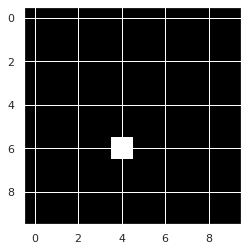

Action Left, Points: 1


KeyboardInterrupt: 

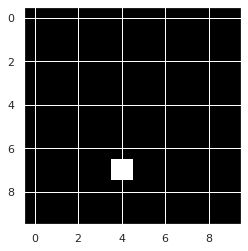

In [46]:
test(model)

## Avaliando o progresso

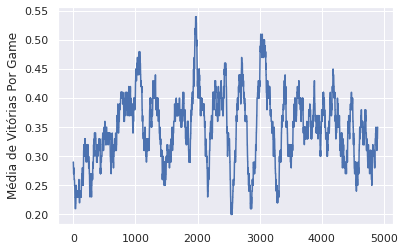

In [47]:
def moving_average_diff(a, n=100):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(hist))
plt.ylabel('Média de Vitórias Por Game')
plt.show()